In [1]:
import pandas as pd
import numpy as np

In [2]:
data_prefix: str = 'data'

all_data = pd.read_parquet(f'{data_prefix}/full_others_code_dataset.parquet')

In [3]:
import re

def remove_comments_from_diff(diff):
    diff = diff.replace('\r\n', '\n')
    state = "ETC"
    i = 0
    comments = []
    current_comment = None

    def find_comments(source):
        nonlocal i, state, current_comment
        while i + 1 < len(source):
            if state == "ETC" and source[i] == '/' and source[i + 1] == '/':
                state = "LINE_COMMENT"
                current_comment = {"type": "LineComment", "range": {"start": i}}
                i += 2
                continue

            if state == "LINE_COMMENT" and source[i] == '\n':
                state = "ETC"
                current_comment["range"]["end"] = i
                comments.append(current_comment)
                current_comment = None
                i += 1
                continue

            if state == "ETC" and source[i] == '/' and source[i + 1] == '*':
                state = "BLOCK_COMMENT"
                current_comment = {"type": "BlockComment", "range": {"start": i}}
                i += 2
                continue

            if state == "BLOCK_COMMENT" and source[i] == '*' and source[i + 1] == '/':
                state = "ETC"
                current_comment["range"]["end"] = i + 2
                comments.append(current_comment)
                current_comment = None
                i += 2
                continue

            i += 1

        # Handle unfinished line comment at the end of the source code
        if current_comment and current_comment["type"] == "LineComment":
            if len(source) > 0 and source[-1] == '\n':
                current_comment["range"]["end"] = len(source) - 1
            else:
                current_comment["range"]["end"] = len(source)
            comments.append(current_comment)

    def remove_content(source, comments):
        result = []
        last_index = 0

        for comment in comments:
            start = comment["range"]["start"]
            end = comment["range"]["end"]
            result.append(source[last_index:start])
            last_index = end

        result.append(source[last_index:])
        return ''.join(result)

    # Process the entire diff content at once
    i = 0
    comments = []
    find_comments(diff)
    clean_diff = remove_content(diff, comments)

    return clean_diff

In [4]:
def remove_comments(source):
    source = source.replace('\r\n', '\n')
    state = "ETC"
    i = 0
    comments = []
    current_comment = None

    while i + 1 < len(source):
        if state == "ETC" and source[i] == '/' and source[i + 1] == '/':
            state = "LINE_COMMENT"
            current_comment = {
                "type": "LineComment",
                "range": {"start": i}
            }
            i += 2
            continue

        if state == "LINE_COMMENT" and source[i] == '\n':
            state = "ETC"
            current_comment["range"]["end"] = i
            comments.append(current_comment)
            current_comment = None
            i += 1
            continue

        if state == "ETC" and source[i] == '/' and source[i + 1] == '*':
            state = "BLOCK_COMMENT"
            current_comment = {
                "type": "BlockComment",
                "range": {"start": i}
            }
            i += 2
            continue

        if state == "BLOCK_COMMENT" and source[i] == '*' and source[i + 1] == '/':
            state = "ETC"
            current_comment["range"]["end"] = i + 2
            comments.append(current_comment)
            current_comment = None
            i += 2
            continue

        i += 1

    # Handle unfinished line comment at the end of the source code
    if current_comment and current_comment["type"] == "LineComment":
        if source[-1] == '\n':
            current_comment["range"]["end"] = len(source) - 1
        else:
            current_comment["range"]["end"] = len(source)
        comments.append(current_comment)

    # Remove the comments from the source code
    def remove_content(source, comments):
        result = []
        last_index = 0

        for comment in comments:
            start = comment["range"]["start"]
            end = comment["range"]["end"]
            # Append code before the comment
            result.append(source[last_index:start])
            # Update last index to skip the comment
            last_index = end

        # Append the remaining source code after the last comment
        result.append(source[last_index:])
        # Join and split lines, then filter out blank lines
        cleaned_code = ''.join(result).split('\n')
        return '\n'.join(line for line in cleaned_code if line.strip())

    return remove_content(source, comments)

In [5]:
len(all_data)

118566

In [6]:
filtered_code_data = all_data[all_data['fileName'].str.contains('.java')]
filtered_code_data

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,startCode,endCode,diff,startCommitChanges,endCommitChanges
3,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,/*\n * Copyright 2006 JBoss Inc\n * \n * Licen...,/*\n * Copyright 2006 JBoss Inc\n * \n * Licen...,diff --git a/drools-compiler/src/main/java/org...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
4,4,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/guvno...,package org.drools.guvnor.server.util;\n\nimpo...,package org.drools.guvnor.server.util;\n\nimpo...,diff --git a/drools-compiler/src/test/java/org...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
5,5,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,package org.drools.integrationtests;\n\nimport...,package org.drools.integrationtests;\n\nimport...,diff --git a/drools-compiler/src/test/java/org...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
6,6,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,package org.drools.integrationtests;\n\nimport...,package org.drools.integrationtests;\n\nimport...,diff --git a/drools-compiler/src/test/java/org...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
7,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,package org.drools.integrationtests;\n\nimport...,package org.drools.integrationtests;\n\nimport...,diff --git a/drools-compiler/src/test/java/org...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118540,118540,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,package ru.yandex.qatools.processors.matcher.g...,package ru.yandex.qatools.processors.matcher.g...,diff --git a/feature-matcher-generator/src/tes...,+ru.qatools.commons:properties\n-ru.yandex.qat...,+ru.qatools.commons:properties\n-ru.yandex.qat...
118541,118541,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,package ru.yandex.qatools.processors.matcher.g...,package ru.yandex.qatools.processors.matcher.g...,diff --git a/feature-matcher-generator/src/tes...,+ru.qatools.commons:properties\n-ru.yandex.qat...,+ru.qatools.commons:properties\n-ru.yandex.qat...
118558,118558,xalan:xalan,net.sourceforge.saxon:saxon,epimorphics_elda,epimorphics,elda,64845b433d6b02eae40c8fcf28161114cdd1a43a,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,elda-lda/src/main/java/com/epimorphics/lda/voc...,/*

In [7]:
# new file created after commit
new_file_df = filtered_code_data[
    (filtered_code_data['startCode'] == '') & (filtered_code_data['endCode'] != '')
]

# file deleted after commit
deleted_df = filtered_code_data[
    (filtered_code_data['startCode'] != '') & (filtered_code_data['endCode'] == '')
]

In [8]:
# Combine rows to be removed from new_file_df and deleted_df
rows_to_remove = pd.concat([new_file_df, deleted_df]).drop_duplicates()

# Filter out rows from original_df that are in rows_to_remove
remain_df = filtered_code_data.merge(rows_to_remove, how='left', indicator=True)
remain_df = remain_df[remain_df['_merge'] == 'left_only'].drop('_merge', axis=1)

In [31]:
unique_commit_repo_mapping = (
    remain_df.groupby(['startCommit', 'endCommit'])
    .agg(repoName=('repoName', 'first'), count=('repoName', 'size'))
    .reset_index()
    .sort_values(by='count', ascending=False)
)

unique_commit_repo_mapping

,startCommit,endCommit,repoName,count
812,d59c7d6f4485bdd578ee5c45dfc421a705d48bc0,2a903b90e3a5fb015d59ccef4ccdde265b1746d8,mulesoft_mule,1920
820,d68640c5a7995fbdbe0aa61dc88b0f0b23b6d5fe,3cfa7b24ee562abfabdf19bc1035c61c3ed3eff2,ProgrammeVitam_vitam,734
53,0e092deee046995b2813e4a130cb61592d9efd84,3cfa7b24ee562abfabdf19bc1035c61c3ed3eff2,ProgrammeVitam_vitam,699
941,fce9eff724e31ee16deb995f5427dce3e90e8238,fce9eff724e31ee16deb995f5427dce3e90e8238,MyCollab_mycollab,644
803,d28d8235630d3a5d2940598a8fd562039a078c57,a881c12aae720a817d1cadc393902d2ba583c762,apache_groovy,642
...,...,...,...,...
347,514ba4e2a3aa8b13b46b9426d3619922428c93db,514ba4e2a3aa8b13b46b9426d3619922428c93db,apache_storm,1
13,0339ab121d7d42eb0aa986c607c9dd236f42aa9a,0339ab121d7d42eb0aa986c607c9dd236f42aa9a,apache_metamodel,1
12,03398119474b015da5b58d69aab27355040e4813,03398119474b015da5b58d69aab27355040e4813,VIPJoey_doe,1
9,02c12e6b264e45b59440e73e02692375d002baa0,02c12e6b264e45b59440e73e02692375d002baa0,apache_wicket,1


In [32]:
unique_commit_repo_mapping.describe()

,count
count,951.000000
mean,22.243954
std,89.105316
min,1.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,1920.000000


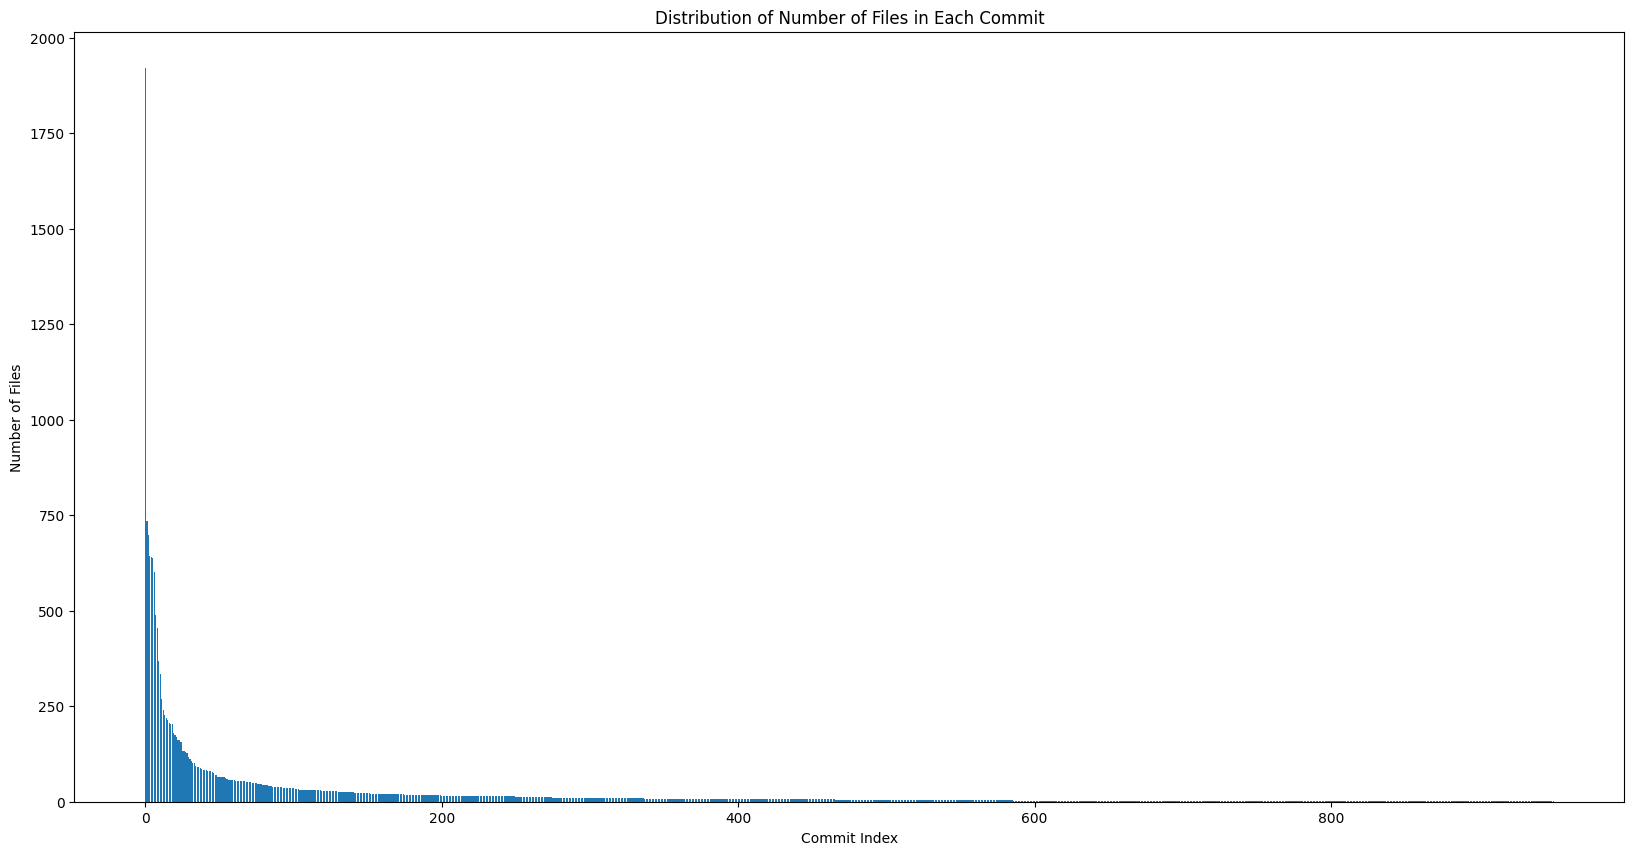

In [33]:
# plot the distribution of the number of files in each commit
# x-axis the index of the commit
# y-axis the number of files in each commit
# use bar chart

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['count'])
plt.xlabel('Commit Index')
plt.ylabel('Number of Files')
plt.title('Distribution of Number of Files in Each Commit')
plt.show()

In [34]:
repoName_counts = unique_commit_repo_mapping['repoName'].value_counts()
repos_more_than_once_counts = repoName_counts[repoName_counts > 1]
len(repos_more_than_once_counts) / len(repoName_counts) # percentage of repos that have more than one commit migrations

0.22644376899696048

In [35]:
check_df = remain_df[(remain_df['repoName'] == 'mulesoft_mule') & (remain_df['startCommit'] == 'd59c7d6f4485bdd578ee5c45dfc421a705d48bc0')]

# check if any duplicate file_Name in check_df
check_df['fileName'].value_counts()

fileName
transports/vm/src/test/java/org/mule/issues/ServiceOverridesMule1770TestCase.java      1
transports/vm/src/test/java/org/mule/issues/TransformerChainMule2063TestCase.java      1
transports/vm/src/test/java/org/mule/issues/TransformerChainMule2131TestCase.java      1
transports/vm/src/test/java/org/mule/transport/vm/PersistentVMQueueTestCase.java       1
transports/vm/src/test/java/org/mule/transport/vm/TransformerAttributeTestCase.java    1
                                                                                      ..
core/src/main/java/org/mule/DefaultMuleEventContext.java                               1
core/src/main/java/org/mule/DefaultMuleMessage.java                                    1
core/src/main/java/org/mule/MessagePropertiesContext.java                              1
core/src/main/java/org/mule/MuleServer.java                                            1
core/src/main/java/org/mule/OptimizedRequestContext.java                               1
Name: count,

In [22]:
def process_diff(diff: str):
    changes = []

    # Initialize counters for current section
    current_added_count = 0
    current_removed_count = 0
    section_identifier = None  # To store the section from the @@ line
    section_count = 0  # To keep track of the number of @@ sections
    lib_changes_count = 0

    for line in diff.splitlines():
        if line.startswith('@@'):
            # If we reach a new change section, append previous counts if any
            if current_added_count > 0 or current_removed_count > 0:
                changes.append({
                    'section_count': section_count,
                    'section_identifier': section_identifier,
                    'added_count': current_added_count,
                    'removed_count': current_removed_count,
                    'line_change': current_added_count - current_removed_count,
                    'lib_changes': lib_changes_count
                })
                # Reset counts for the new section
                current_added_count = 0
                current_removed_count = 0
                lib_changes_count = 0

            # Extract the old and new line numbers from the @@ line
            parts = line.split()
            old_line_info = parts[1]  # e.g., -16,14
            new_line_info = parts[2]  # e.g., +16,14

            # Get the old and new line numbers
            old_start = int(old_line_info.split(',')[0][1:])  # Skip the '-'
            new_start = int(new_line_info.split(',')[0][1:])  # Skip the '+'

            # Store the start line numbers
            section_identifier = {
                'old_start': old_start,
                'new_start': new_start
            }
            section_count += 1

        elif line.startswith('+'):
            # Count added lines
            current_added_count += 1
            if "import" in line:
                lib_changes_count += 1

        elif line.startswith('-'):
            # Count removed lines
            current_removed_count += 1
            if "import" in line:
                lib_changes_count += 1

    # Append any remaining counts after the last section
    if current_added_count > 0 or current_removed_count > 0:
        changes.append({
            'section_count': section_count,
            'section_identifier': section_identifier,
            'added_count': current_added_count,
            'removed_count': current_removed_count,
            'line_change': current_added_count - current_removed_count,
            'lib_changes': lib_changes_count
        })

    return changes

In [9]:
len(remain_df)

35038

In [10]:
remain_df['startCode_cleaned'] = remain_df['startCode'].apply(remove_comments)

In [11]:
remain_df['endCode_cleaned'] = remain_df['endCode'].apply(remove_comments)

In [12]:
# remove comment from diff
remain_df['diff'] = remain_df['diff'].apply(remove_comments_from_diff)

In [16]:
import difflib

# Calculate the diff for each row
remain_df['diff_cleaned'] = remain_df.apply(
    lambda x: '\n'.join(list(difflib.unified_diff(
        x['startCode_cleaned'].splitlines(),
        x['endCode_cleaned'].splitlines(),
        lineterm=""
    ))),
    axis=1
)

In [23]:
# for each migration in unique_commit_repo_mapping
# get the corresponding rows in remain_df
remain_df['total_added'] = 0
remain_df['total_removed'] = 0
remain_df['total_position'] = 0
remain_df['detailed_changes'] = None
for index, row in remain_df.iterrows():
    total_added = 0
    total_removed = 0
    total_position = 0
    total_lib_change = 0
    diff = row['diff_cleaned']
    changes = process_diff(diff)
    total_position = len(changes)
    for change in changes:
        if change['section_identifier'] != None:
            total_added += change['added_count']
            total_removed += change['removed_count']
            total_lib_change += change['lib_changes']
    remain_df.at[index, 'total_added'] = total_added
    remain_df.at[index, 'total_removed'] = total_removed
    remain_df.at[index, 'total_position'] = total_position
    remain_df.at[index, 'detailed_changes'] = [change for change in changes if change['section_identifier'] != None]
    if (total_added + total_removed == 0):
        remain_df.at[index, 'lib_percentage'] = 0
    else:
        remain_df.at[index, 'lib_percentage'] = total_lib_change / (total_added + total_removed)
            

In [24]:
remain_df

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,startCommitChanges,endCommitChanges,startCode_cleaned,endCode_cleaned,diff_cleaned,total_added,total_removed,total_position,detailed_changes,lib_percentage
0,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.rule.builder.dialect.java;\...,package org.drools.rule.builder.dialect.java;\...,"--- \n+++ \n@@ -178,7 +178,6 @@\n cons...",1,2,3,"[{'section_count': 1, 'section_identifier': {'...",0.000000
1,4,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/guvno...,...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.guvnor.server.util;\nimport...,package org.drools.guvnor.server.util;\nimport...,"--- \n+++ \n@@ -3,11 +3,9 @@\n import org.droo...",13,18,3,"[{'section_count': 1, 'section_identifier': {'...",0.096774
2,5,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -11,8 +11,6 @@\n import org.dro...",0,7,3,"[{'section_count': 1, 'section_identifier': {'...",1.000000
3,6,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,,0,0,0,[],0.000000
4,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -436,9 +436,8 @@\n ...",5,8,5,"[{'section_count': 1, 'section_identifier': {'...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57640,118540,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,+ru.qatools.commons:properties\n-ru.yandex.qat...,package ru.yandex.qatools.processors.matcher.g...,package ru.yandex.qatools.processors.matcher.g...,"--- \n+++ \n@@ -1,5 +1,4 @@\n package ru.yande...",7,7,6,"[{'section_count': 1, 'section_identifier': {'...",0.285714
57641,118541,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,+ru.qatools.comm

In [25]:
count = (remain_df['lib_percentage'] == 1).sum()
proportion = count / len(remain_df)
proportion

np.float64(0.27144814201723844)

In [26]:
# remain_df remove rows with lib_percentage == 1
remain_df = remain_df[remain_df['lib_percentage'] != 1]
remain_df = remain_df[(remain_df['total_added'] != 0) | (remain_df['total_removed'] != 0)]

In [27]:
len(remain_df)

21154

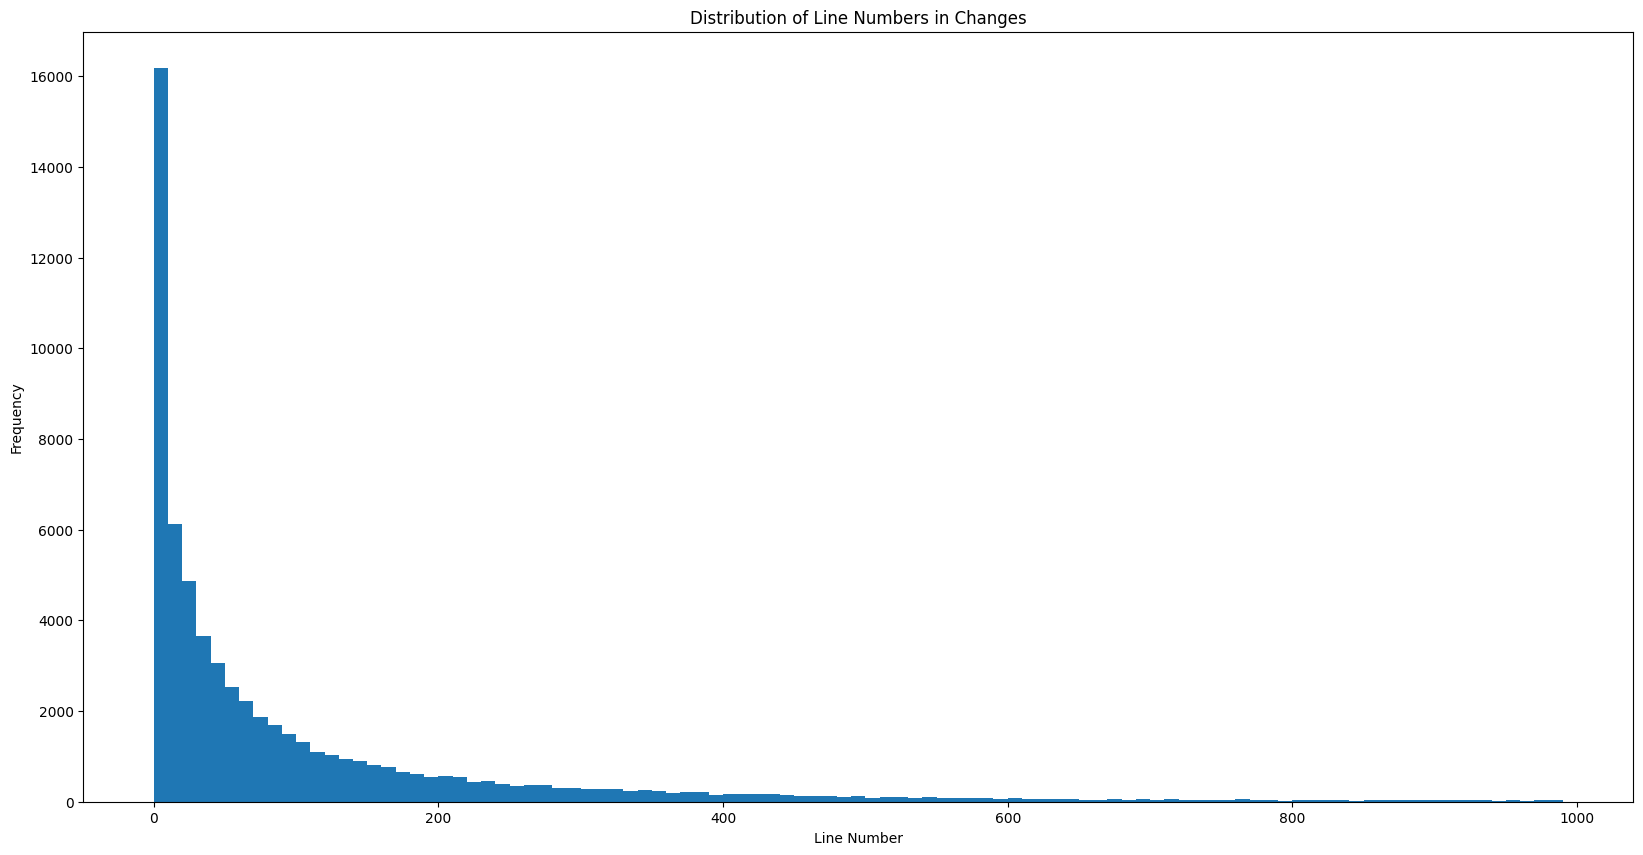

In [36]:
changes_position = []
for index, row in remain_df.iterrows():
    detailed_changes = row['detailed_changes']
    if detailed_changes != None:
        for change in detailed_changes:
            changes_position.append(change['section_identifier']['old_start'])

plt.figure(figsize=(20, 10))
plt.hist(changes_position, bins=range(0, 1000, 10))
plt.xlabel('Line Number')
plt.ylabel('Frequency')
plt.title('Distribution of Line Numbers in Changes')

plt.show()

In [37]:
# give the statistics of the line numbers
# mean, median, min, max, std
line_numbers = pd.Series(changes_position)
line_numbers.describe()

count     64559.000000
mean        469.030127
std        5039.283359
min           0.000000
25%           9.000000
50%          44.000000
75%         143.000000
max      142360.000000
dtype: float64

In [38]:
# for each migration in unique_commit_repo_mapping
# get the corresponding rows in remain_df

# get the total number of added lines, removed lines, and the number of files in each migration

for index, row in unique_commit_repo_mapping.iterrows():
    startCommit = row['startCommit']
    endCommit = row['endCommit']
    migration_df = remain_df[(remain_df['startCommit'] == startCommit) & (remain_df['endCommit'] == endCommit)]
    total_added = migration_df['total_added'].sum()
    total_removed = migration_df['total_removed'].sum()
    unique_commit_repo_mapping.at[index, 'total_added'] = total_added
    unique_commit_repo_mapping.at[index, 'total_removed'] = total_removed
    unique_commit_repo_mapping.at[index, 'delta'] = total_added - total_removed
    if len(migration_df) == 0:
        # remove the row if there is no file in the migration
        unique_commit_repo_mapping = unique_commit_repo_mapping.drop(index)
        continue
    unique_commit_repo_mapping.at[index, 'avg_added_in_file'] = total_added / len(migration_df)
    unique_commit_repo_mapping.at[index, 'avg_removed_in_file'] = total_removed / len(migration_df)
    unique_commit_repo_mapping.at[index, 'file_count_no_only_lib'] = len(migration_df)

unique_commit_repo_mapping

,startCommit,endCommit,repoName,count,total_added,total_removed,delta,avg_added_in_file,avg_removed_in_file,file_count_no_only_lib
812,d59c7d6f4485bdd578ee5c45dfc421a705d48bc0,2a903b90e3a5fb015d59ccef4ccdde265b1746d8,mulesoft_mule,1920,42589.0,19505.0,23084.0,22.181771,10.158854,1920.0
820,d68640c5a7995fbdbe0aa61dc88b0f0b23b6d5fe,3cfa7b24ee562abfabdf19bc1035c61c3ed3eff2,ProgrammeVitam_vitam,734,74611.0,40080.0,34531.0,101.649864,54.604905,734.0
53,0e092deee046995b2813e4a130cb61592d9efd84,3cfa7b24ee562abfabdf19bc1035c61c3ed3eff2,ProgrammeVitam_vitam,699,67917.0,38535.0,29382.0,97.163090,55.128755,699.0
941,fce9eff724e31ee16deb995f5427dce3e90e8238,fce9eff724e31ee16deb995f5427dce3e90e8238,MyCollab_mycollab,644,5032.0,3487.0,1545.0,7.813665,5.414596,644.0
803,d28d8235630d3a5d2940598a8fd562039a078c57,a881c12aae720a817d1cadc393902d2ba583c762,apache_groovy,642,32496.0,22846.0,9650.0,50.616822,35.585670,642.0
...,...,...,...,...,...,...,...,...,...,...
347,514ba4e2a3aa8b13b46b9426d3619922428c93db,514ba4e2a3aa8b13b46b9426d3619922428c93db,apache_storm,1,11.0,11.0,0.0,11.000000,11.000000,1.0
13,0339ab121d7d42eb0aa986c607c9dd236f42aa9a,0339ab121d7d42eb0aa986c607c9dd236f42aa9a,apache_metamodel,1,3.0,3.0,0.0,3.000000,3.000000,1.0
12,03398119474b015da5b58d69aab27355040e4813,03398119474b015da5b58d69aab27355040e4813,VIPJoey_doe,1,1.0,0.0,1.0,1.000000,0.000000,1.0
9,02c12e6b264e45b59440e73e02692375d002baa0,02c12e6b264e45b59440e73e02692375d002baa0,apache_wicket,1,4.0,4.0,0.0,4.000000,4.000000,1.0


In [39]:
unique_commit_repo_mapping['file_count_no_only_lib'].describe()

count     951.000000
mean       22.243954
std        89.105316
min         1.000000
25%         2.000000
50%         5.000000
75%        14.000000
max      1920.000000
Name: file_count_no_only_lib, dtype: float64

In [40]:
tmp = unique_commit_repo_mapping[unique_commit_repo_mapping['file_count_no_only_lib'] < 1000]['file_count_no_only_lib']
tmp.describe()

count    950.000000
mean      20.246316
std       64.413544
min        1.000000
25%        2.000000
50%        5.000000
75%       14.000000
max      734.000000
Name: file_count_no_only_lib, dtype: float64

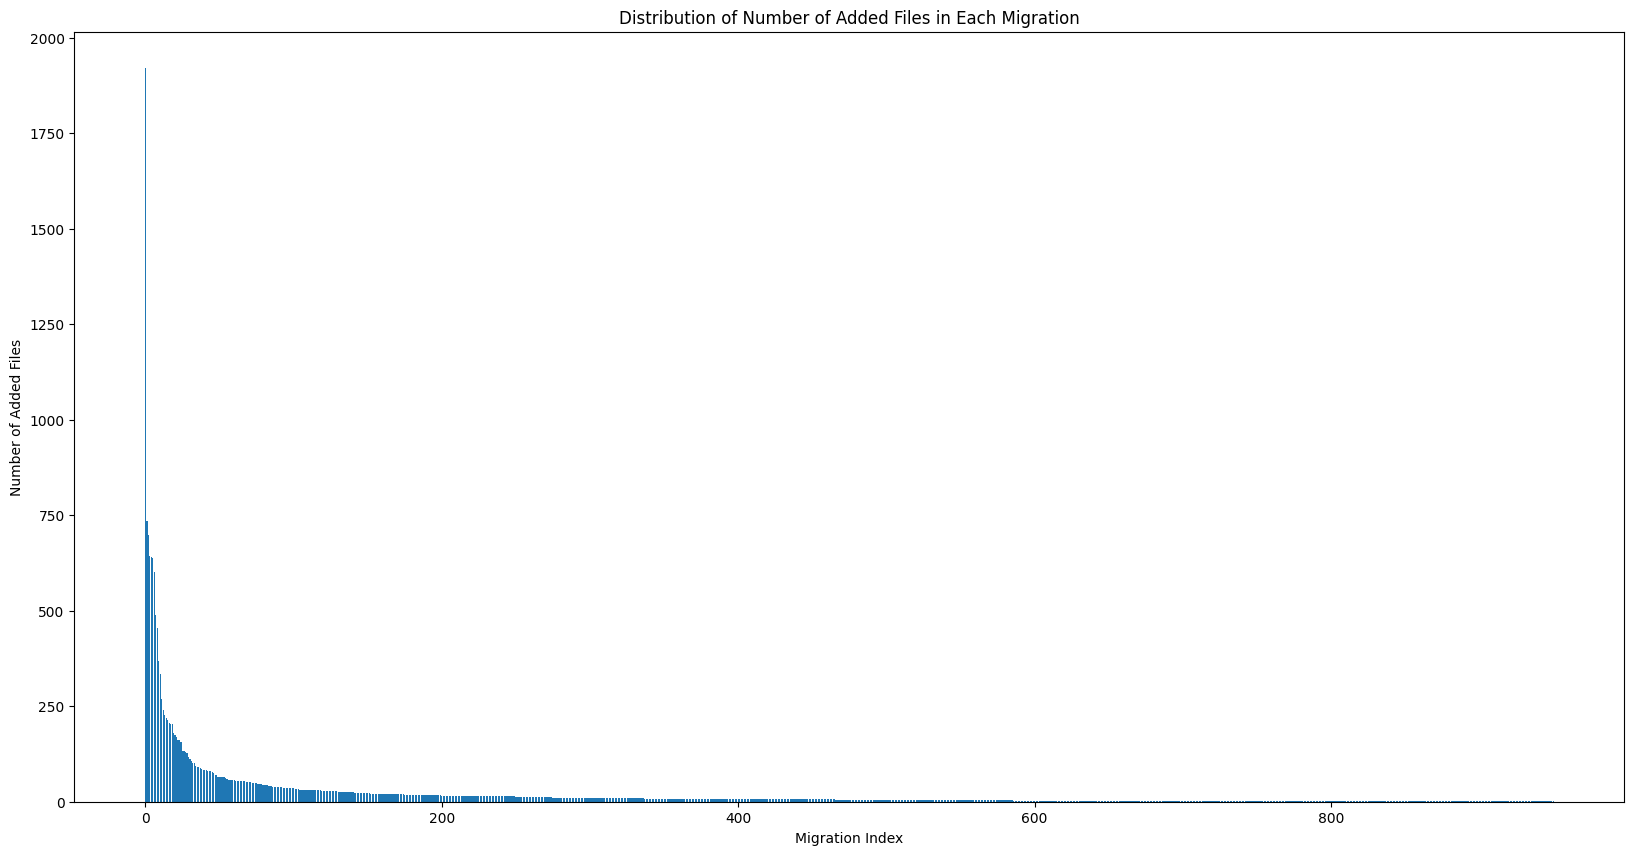

In [41]:

plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['file_count_no_only_lib'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Added Files')
plt.title('Distribution of Number of Added Files in Each Migration')
plt.show()

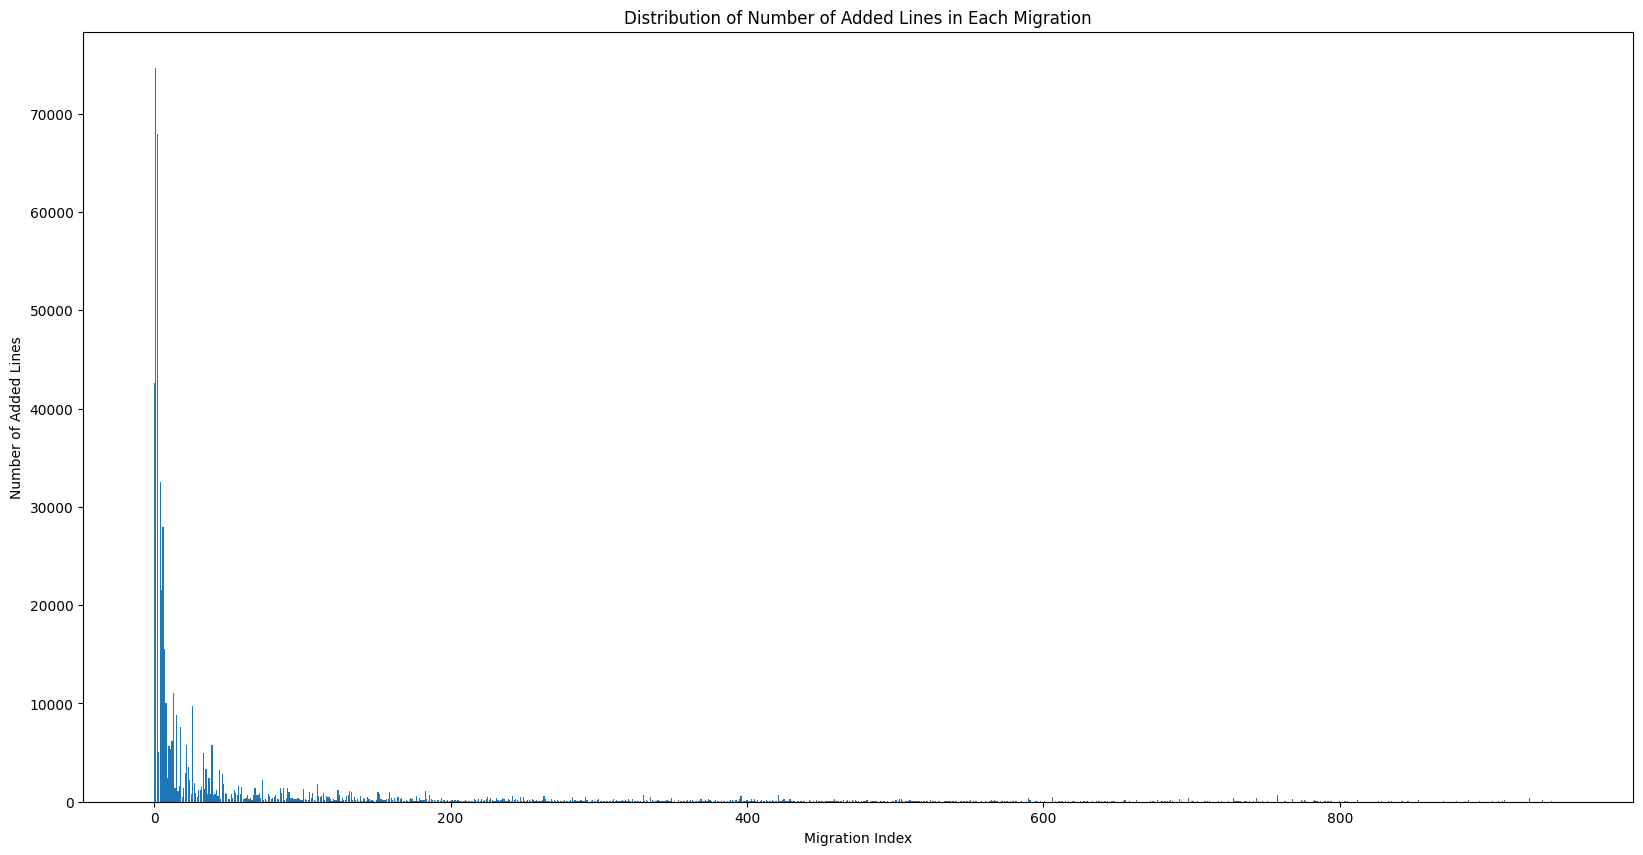

In [42]:
# plot the distribution of the number of added lines in each migration
# x-axis the index of the migration
# y-axis the number of added lines in each migration
# use bar chart

plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['total_added'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Added Lines')
plt.title('Distribution of Number of Added Lines in Each Migration')
plt.show()

In [43]:
t = unique_commit_repo_mapping[unique_commit_repo_mapping['total_added'] < 8000]['total_added']
t.describe()

count     940.000000
mean      223.520213
std       641.263287
min         0.000000
25%        12.000000
50%        49.000000
75%       167.500000
max      7577.000000
Name: total_added, dtype: float64

In [44]:
unique_commit_repo_mapping['total_added'].describe()

count      951.000000
mean       559.785489
std       3982.435720
min          0.000000
25%         12.000000
50%         50.000000
75%        171.500000
max      74611.000000
Name: total_added, dtype: float64

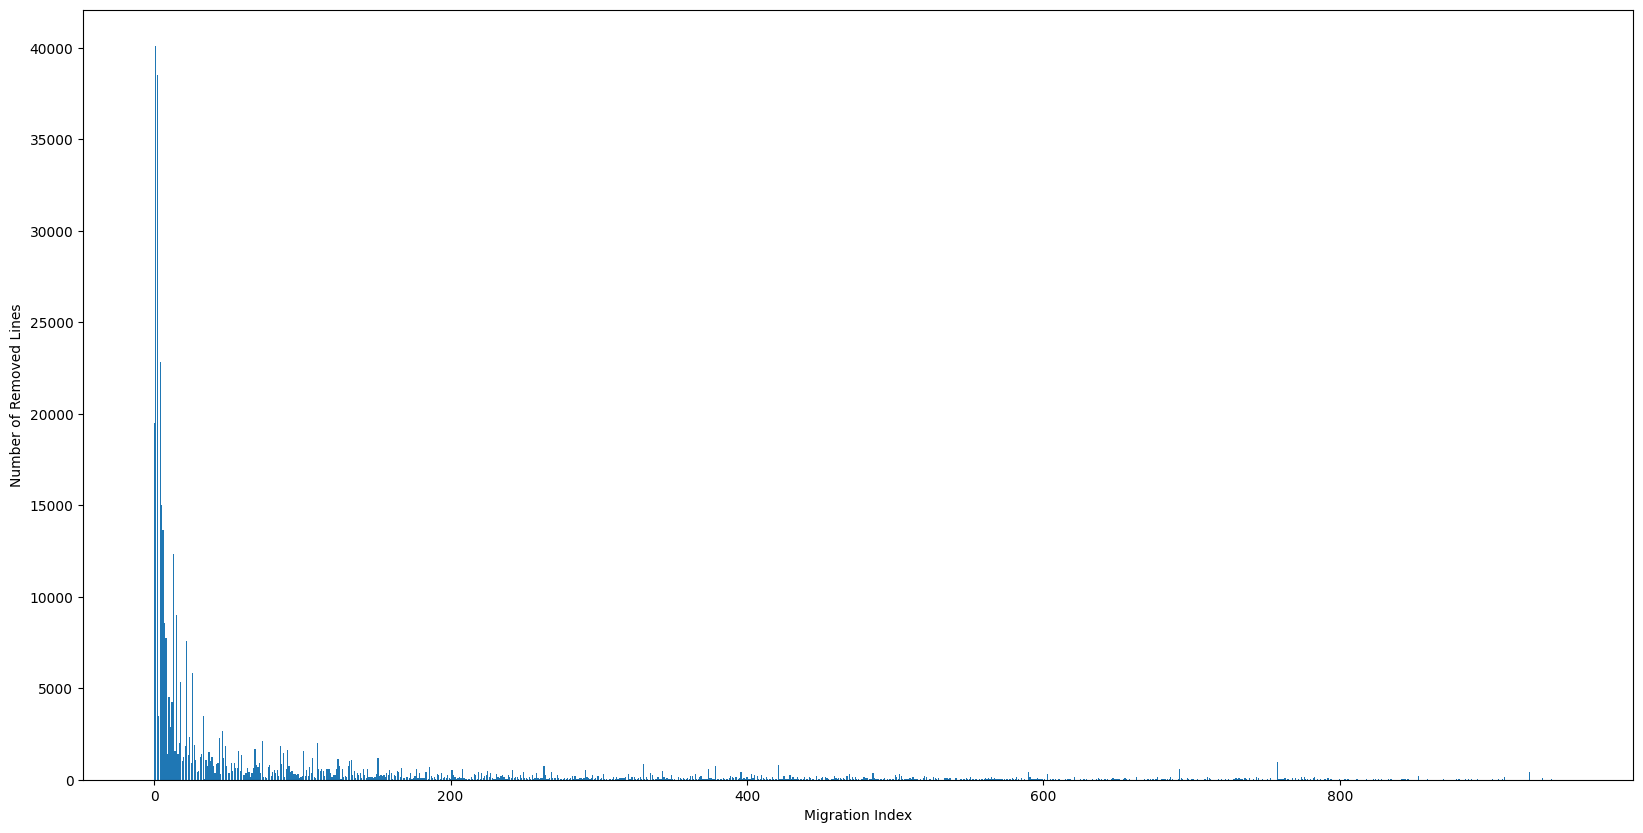

In [45]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['total_removed'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Removed Lines')
plt.show()

In [46]:
unique_commit_repo_mapping['total_removed'].describe()

count      951.000000
mean       401.579390
std       2279.470192
min          0.000000
25%         12.000000
50%         48.000000
75%        162.500000
max      40080.000000
Name: total_removed, dtype: float64

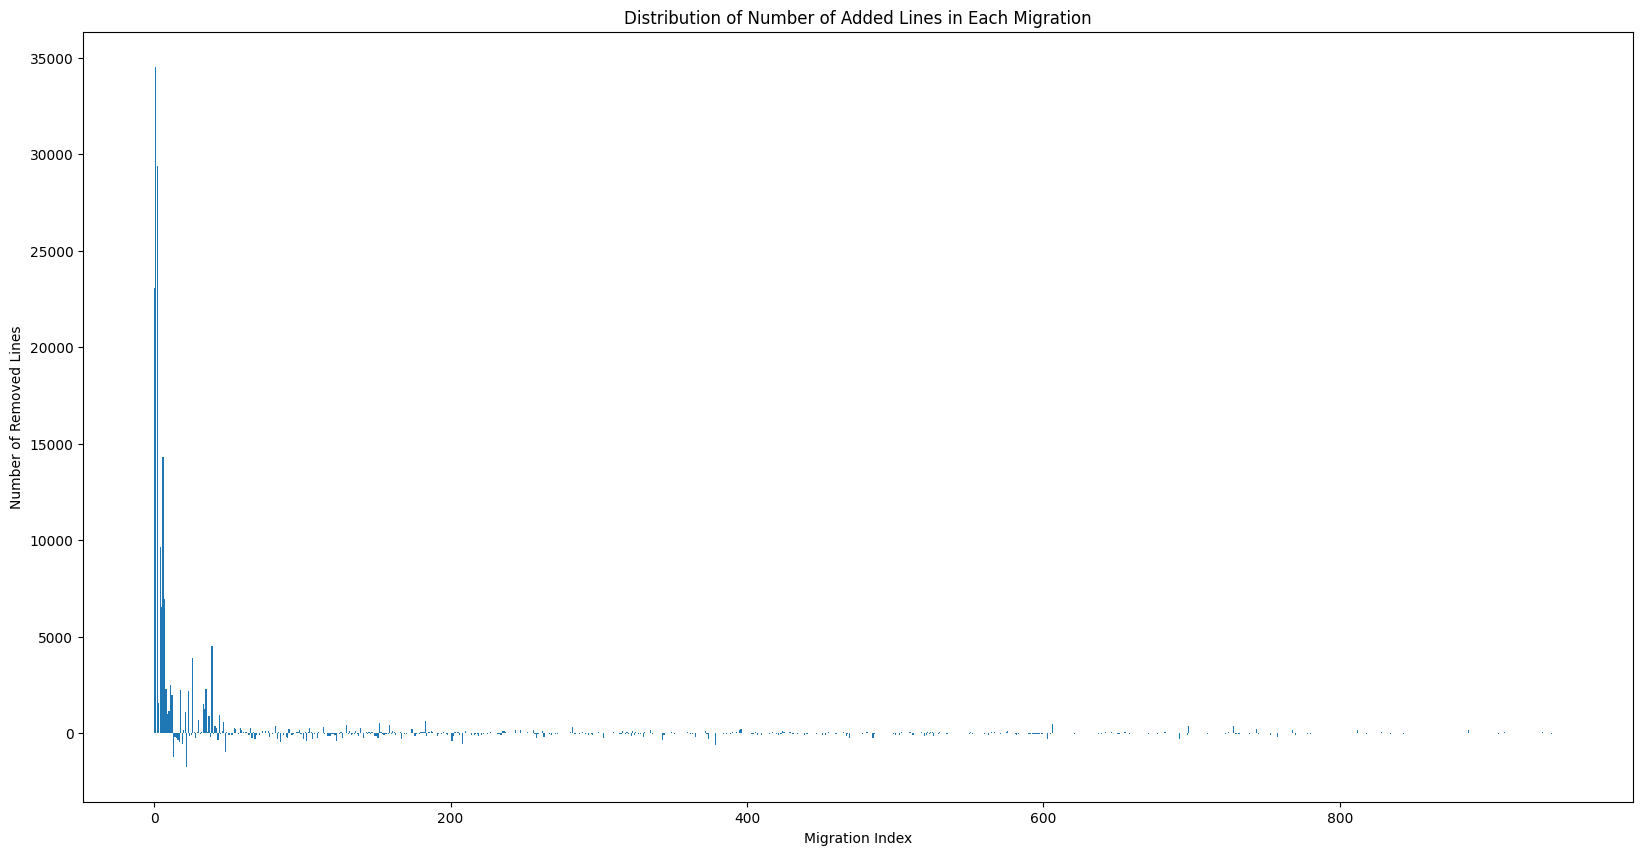

In [47]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['delta'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Removed Lines')
plt.title('Distribution of Number of Added Lines in Each Migration')
plt.show()

In [48]:
unique_commit_repo_mapping['delta'].describe()

count      951.000000
mean       158.206099
std       1790.735167
min      -1735.000000
25%        -11.000000
50%          0.000000
75%         17.000000
max      34531.000000
Name: delta, dtype: float64

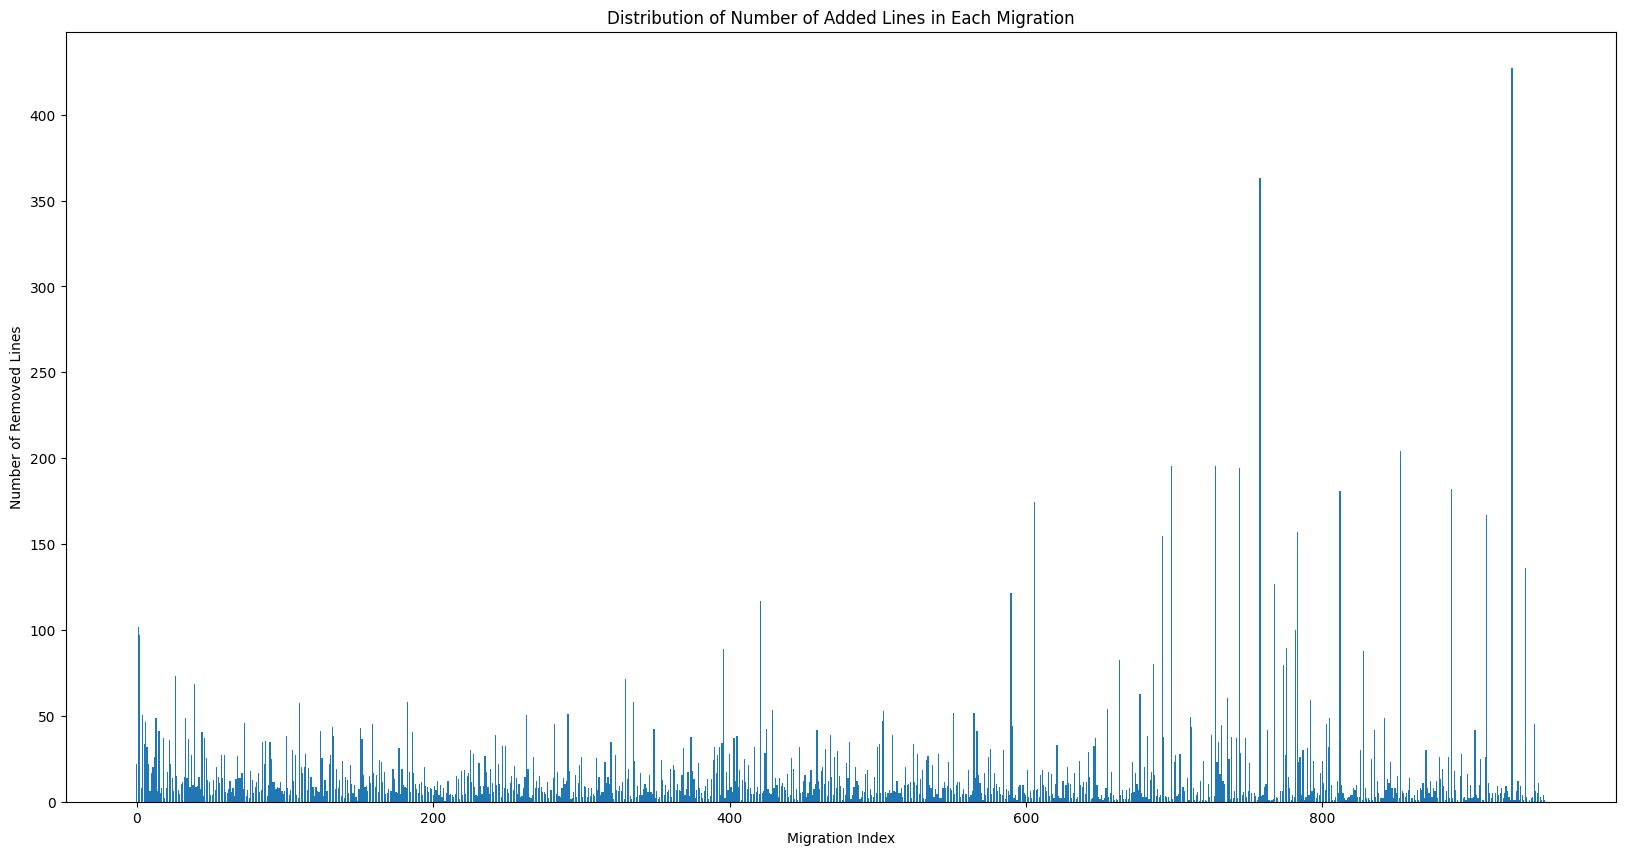

In [49]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['avg_added_in_file'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Removed Lines')
plt.title('Distribution of Number of Added Lines in Each Migration')
plt.show()

In [50]:
unique_commit_repo_mapping['avg_added_in_file'].describe()

count    951.000000
mean      16.133373
std       29.249383
min        0.000000
25%        4.000000
50%        8.166667
75%       17.329389
max      427.000000
Name: avg_added_in_file, dtype: float64

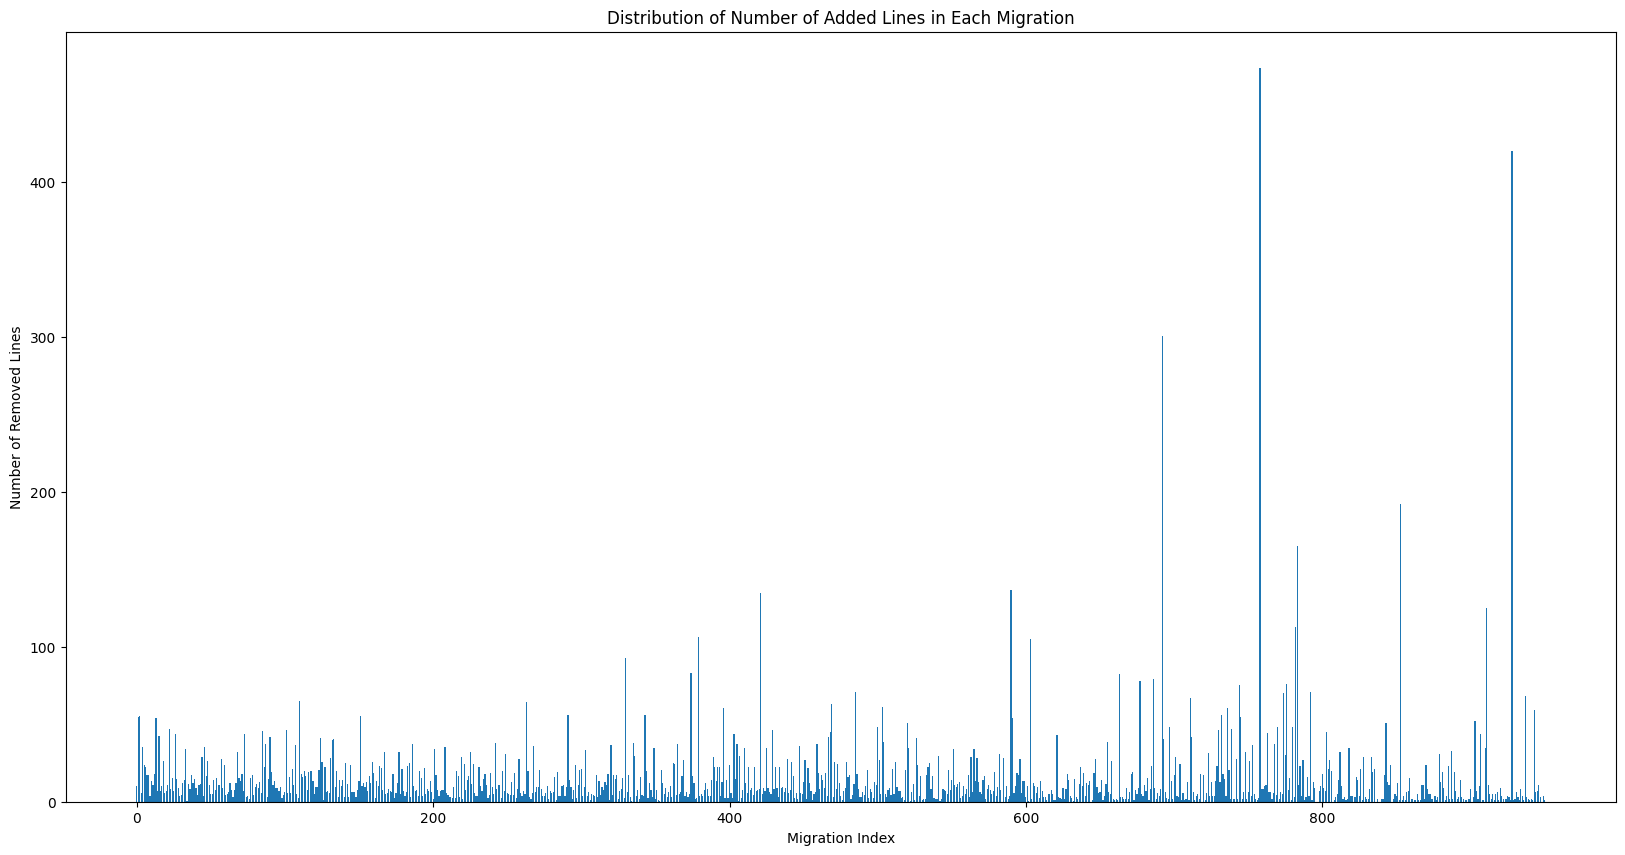

In [51]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(unique_commit_repo_mapping)), unique_commit_repo_mapping['avg_removed_in_file'])
plt.xlabel('Migration Index')
plt.ylabel('Number of Removed Lines')
plt.title('Distribution of Number of Added Lines in Each Migration')
plt.show()

In [52]:
unique_commit_repo_mapping['avg_removed_in_file'].describe()

count    951.000000
mean      15.184690
std       28.489054
min        0.000000
25%        3.594872
50%        8.000000
75%       17.531876
max      473.500000
Name: avg_removed_in_file, dtype: float64

In [53]:
def check_new_import(startCode: str):
    for line in startCode.splitlines():
        if line.startswith('import'):
            return True
    return False

In [54]:
# count the number of files that add new import statements
# count the number of files that replace the import statements

import_count = 0
replace_count = 0

for index, row in remain_df.iterrows():
    startCode = row['startCode']
    if check_new_import(startCode):
        replace_count += 1
    else:
        import_count += 1

import_count, replace_count

(928, 20226)

In [55]:
# check number of annotations changed in each migration

def process_diff_annotations(diff: str):
    lines = diff.splitlines()
    count = 0
    for line in lines:
        if line.startswith('+') or line.startswith('-'):
            if '@' in line:
                count += 1

    return count

In [56]:
for index, row in remain_df.iterrows():
    diff = row['diff']
    annotation_diffs = process_diff_annotations(diff)
    total_changed = row['total_added'] + row['total_removed']

    remain_df.at[index, 'annotation_change'] = annotation_diffs / (row['total_added'] + row['total_removed'])

In [57]:
# annotation change > 0.8
count = (remain_df['annotation_change'] >= 0.75).sum()

count / len(remain_df)

count

np.int64(515)

In [61]:
# sample from remain_df line that has lib_percentage = 0.0

sample = remain_df.sample(n = 500, random_state = 18022004)

In [62]:
# save the sample to a csv file
sample.to_csv('data/500_sample_no_comment.csv', index=False)

In [59]:
# write full remain_df to parquet file
remain_df.to_parquet('data/no_comment_dataset.parquet')

In [63]:
# test read the parquet file
test = pd.read_parquet('data/no_comment_dataset.parquet')

In [70]:
test

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,endCommitChanges,startCode_cleaned,endCode_cleaned,diff_cleaned,total_added,total_removed,total_position,detailed_changes,lib_percentage,annotation_change
0,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.rule.builder.dialect.java;\...,package org.drools.rule.builder.dialect.java;\...,"--- \n+++ \n@@ -178,7 +178,6 @@\n cons...",1,2,3,"[{'added_count': 0, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
1,4,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/guvno...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.guvnor.server.util;\nimport...,package org.drools.guvnor.server.util;\nimport...,"--- \n+++ \n@@ -3,11 +3,9 @@\n import org.droo...",13,18,3,"[{'added_count': 1, 'lib_changes': 3, 'line_ch...",0.096774,0.000000
4,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -436,9 +436,8 @@\n ...",5,8,5,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
6,9,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport s...,"--- \n+++ \n@@ -1,4 +1,8 @@\n package org.droo...",16,28,12,"[{'added_count': 4, 'lib_changes': 4, 'line_ch...",0.227273,0.000000
7,10,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -110,6 +110,7 @@\n }\n ...",1,0,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57638,118538,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,package ru.yandex.qatools.processors.matcher.g...,package ru.yandex.qatools.processors.matcher.g...,"--- \n+++ \n@@ -3,7 +3,6 @@\n import org.junit...",1,9,3,"[{'added_count': 0, 'lib_changes': 1, 'line_ch...",0.200000,0.100000
57639,118539,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,package ru.yandex.qatools.processors.match